In [40]:
import numpy as np
import pandas as pd

from itertools import groupby
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score
from pandas.api.types import is_datetime64_ns_dtype

import lightgbm as lgb
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import gc

import warnings
warnings.filterwarnings("ignore")

In [41]:
TRAIN_PATH = '/kaggle/input/zzz-data/Zzzs_train.parquet'

In [42]:
series_id  = pd.read_parquet(TRAIN_PATH, columns=['series_id'])
series_id = series_id['series_id'].unique()

weird_series = ['31011ade7c0a', 'a596ad0b82aa']
series_id = [s for s in series_id if s not in weird_series]

In [43]:
def basic_fe(df, periods):
    
    df['series_id'] = df['series_id'].astype('category')
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df['hour'] = df["timestamp"].dt.hour
    
    df.sort_values(['timestamp'], inplace=True)
    df.set_index('timestamp', inplace=True)
    
    df['lids'] = np.maximum(0., df['enmo'] - 0.02)
    df['lids'] = df['lids'].rolling(f'{120*5}s', center=True, min_periods=1).agg('sum')
    df['lids'] = 100 / (df['lids'] + 1)
    df['lids'] = df['lids'].rolling(f'{360*5}s', center=True, min_periods=1).agg('mean').astype(np.float16)
    
    df["enmo"] = (df["enmo"]*1000).astype(np.int16)
    df["anglez"] = df["anglez"].astype(np.int16)
    df["anglezdiffabs"] = df["anglez"].diff().abs().astype(np.float16)
    
    for col in ['enmo', 'anglez', 'anglezdiffabs']:
        for p in periods:
            rol_args = {'window':f'{p+5}s', 'min_periods':10, 'center':True}
            
            for agg in ['mean', 'max', 'min']:
                df[f'{col}_{p}_{agg}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float16).values
                gc.collect()
            # There was an overflow error when trying to cast to float16, so I decided to leave it as float32
            for agg in ['var']:
                df[f'{col}_{p}_{agg}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float32).values
                gc.collect()

            
            df[f'{col}_{p}_amplit'] = df[f'{col}_{p}_max'] - df[f'{col}_{p}_min']
            df[f'{col}_diff_{p}_max'] = df[f'{col}_{p}_max'].diff().abs().rolling(**rol_args).max().astype(np.float16)
            df[f'{col}_diff_{p}_mean'] = df[f'{col}_{p}_min'].diff().abs().rolling(**rol_args).mean().astype(np.float16)
            gc.collect()
 
    df.reset_index(inplace=True)
    df.dropna(inplace=True)
    gc.collect()

    return df

In [44]:
def feat_eng_by_id(idx, periods):
    
    from warnings import simplefilter 
    simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    
    df = pd.read_parquet(TRAIN_PATH, filters=[('series_id','=',idx)])
    df['awake'] = df['awake'].astype(np.int8)
    df = basic_fe(df, periods)
    
    return df

In [45]:
periods = [60, 300, 600, 3600] 

In [46]:
dfs = []
for i in tqdm(series_id):
    result = feat_eng_by_id(i, periods)
    dfs.append(result)
df = pd.concat(dfs, ignore_index=True)

100%|██████████| 35/35 [14:28<00:00, 24.81s/it]


In [47]:
features = [col for col in df.columns if col not in ['timestamp', 'series_id', 'step', 'awake']]

In [48]:
features_to_drop = ['anglezdiffabs_3600_min', 'anglezdiffabs_600_min', 'anglezdiffabs_diff_3600_mean', 'anglezdiffabs_diff_600_mean',
                        'enmo_3600_min', 'enmo_600_min']
for p in periods:
    features_to_drop.append(f'anglezdiffabs_{p}_amplit')
    features_to_drop.append(f'enmo_{p}_amplit')

In [49]:
corr_with_target = df[features].corrwith(df['awake'])
corr_with_target.abs().sort_values().tail(50)

anglez_3600_min                 0.300191
anglez_3600_max                 0.301631
anglez_diff_3600_mean           0.302583
enmo_60_max                     0.305192
anglezdiffabs_diff_60_max       0.314172
enmo_diff_300_max               0.317025
anglezdiffabs_diff_3600_max     0.320073
anglezdiffabs_60_var            0.322677
enmo_60_mean                    0.325824
anglez_diff_60_max              0.337915
anglez_diff_60_mean             0.339530
anglezdiffabs_diff_60_mean      0.344148
anglezdiffabs                   0.347098
enmo_diff_600_max               0.348327
anglez_300_min                  0.360647
anglez_diff_3600_max            0.363111
enmo_300_max                    0.368225
enmo_300_amplit                 0.369672
anglez_600_min                  0.380604
anglez_300_max                  0.385129
enmo_300_mean                   0.387068
enmo_600_max                    0.404006
anglez_600_max                  0.405358
enmo_600_amplit                 0.405517
enmo_diff_3600_m

In [50]:
features_for_heatmap = corr_with_target.abs().sort_values().tail(27).index.to_list()
features_for_heatmap = [f for f in features_for_heatmap if f not in ['anglezdiffabs_3600_min','anglezdiffabs_diff_3600_mean']]

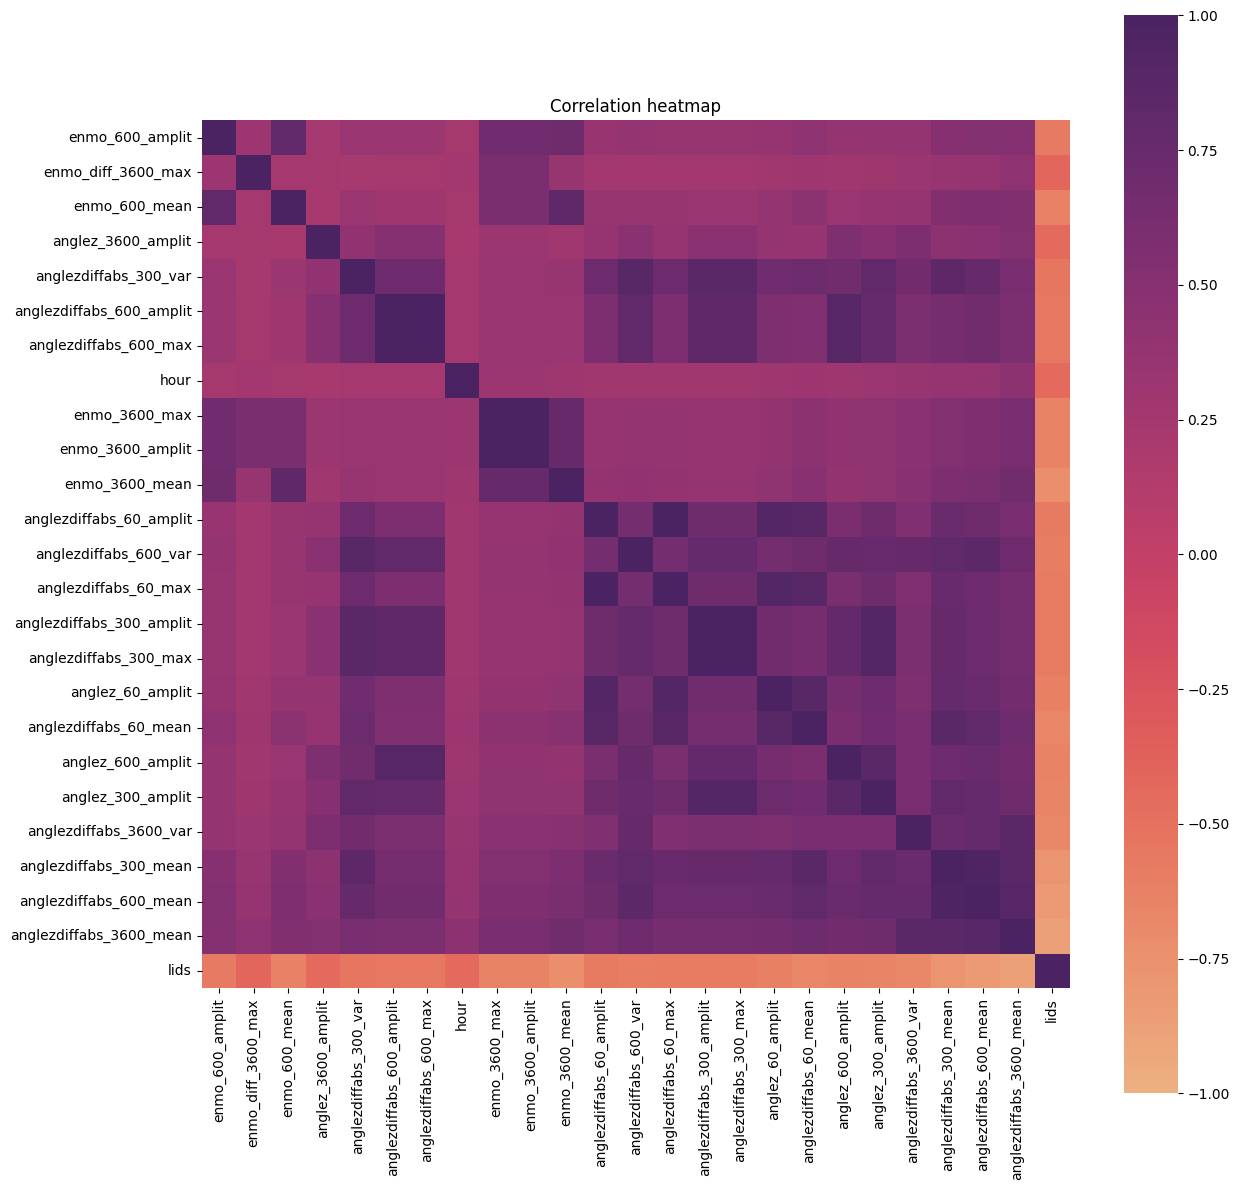

In [51]:
plt.figure(figsize=(14,14))
plt.title(f"Correlation heatmap")
sns.heatmap(df[features_for_heatmap].corr(),
vmin=-1, vmax=1, center=0,
cmap=sns.color_palette("flare", as_cmap=True),
square=True)
plt.show() 

In [52]:
df = df[::50]

In [63]:
from tqdm import tqdm
def train_model(df, cv):
    drop_cols = ['series_id', 'step', 'timestamp']
    X, y = df.drop(columns=drop_cols + ['awake']), df['awake']
    gc.collect()
    
    cv = cv
    models = []
    mean_f1 = 0
    mean_acc = 0
    
    for i, (train_index, test_index) in enumerate(cv.split(X)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        print(f"Fitting model {i + 1} of {cv.n_splits}")
        
        # Initialize RandomForestClassifier
        rf = RandomForestClassifier(random_state=42, n_jobs=-1)
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        preds = rf.predict(X_test)
        f1 = f1_score(y_test, preds)
        acc = accuracy_score(y_test, preds)
        
        print(f"Fold {i + 1} finished training\nF1: {f1} | Acc: {acc}")
        mean_f1 += f1
        mean_acc += acc
        models.append(rf)
        
    print('-' * 50)
    print(f"Training finished\nF1: {mean_f1 / cv.n_splits}, Acc: {mean_acc / cv.n_splits}")
    gc.collect()
    
    return models

In [64]:
print(f"Fitting model with all {len(features)} features")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = train_model(df, kf)

Fitting model with all 89 features
Fitting model 1 of 5
Fold 1 finished training
F1: 0.9843847595252967 | Acc: 0.9795864111961413
Fitting model 2 of 5
Fold 2 finished training
F1: 0.9846073344089303 | Acc: 0.9798902413550825
Fitting model 3 of 5
Fold 3 finished training
F1: 0.9847222222222223 | Acc: 0.9799468287124953
Fitting model 4 of 5
Fold 4 finished training
F1: 0.9849259328979568 | Acc: 0.9802316748955564
Fitting model 5 of 5
Fold 5 finished training
F1: 0.9844129760882536 | Acc: 0.9796619825294341
--------------------------------------------------
Training finished
F1: 0.9846106450285319, Acc: 0.9798634277377418


In [67]:
fi = pd.DataFrame([pd.Series(model.feature_importances_, index=features) for model in models])
feature_importance = fi.mean(axis=0).sort_values()

<Axes: >

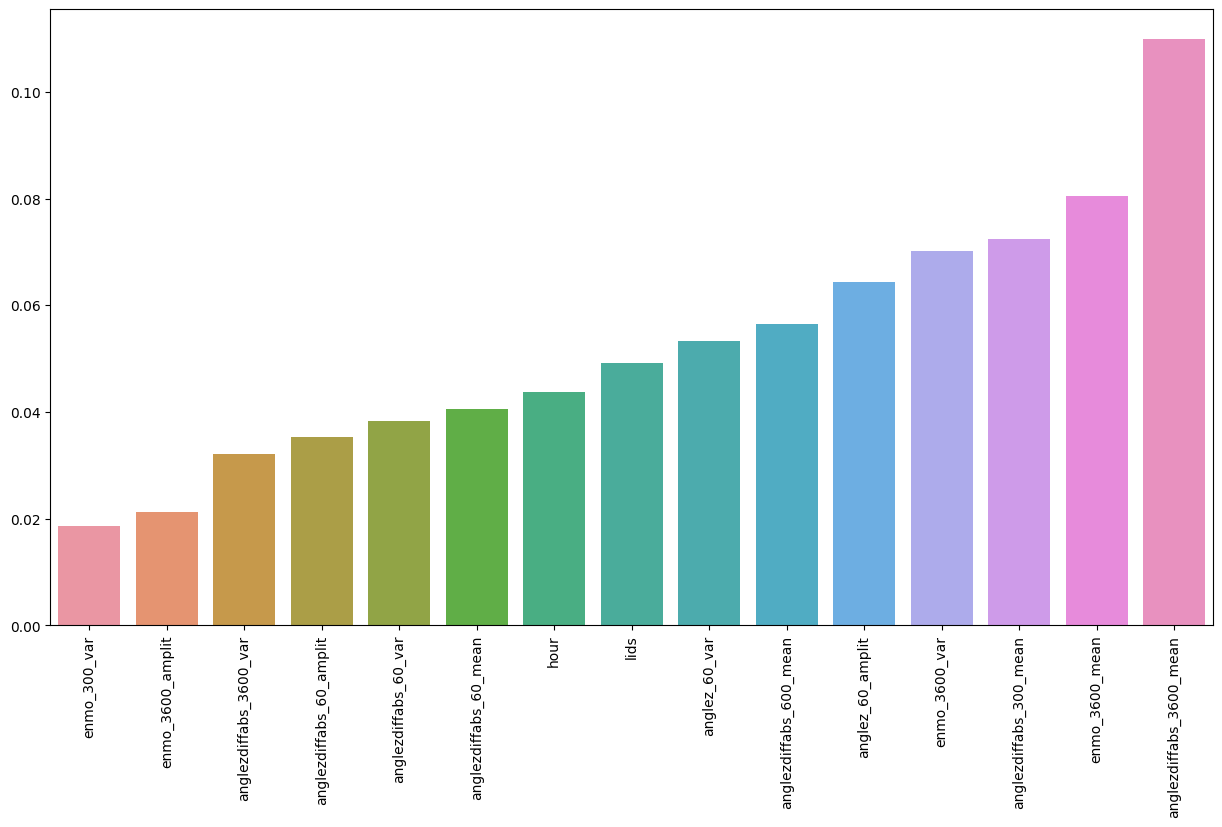

In [68]:
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
sns.barplot(x=feature_importance[-15:].index, y=feature_importance[-15:].values)

In [69]:
df = df.drop(columns=features_to_drop)
features = [col for col in df.columns if col not in ['timestamp', 'series_id', 'step', 'awake']]

In [70]:
print(f"Fitting model with {len(df.columns)-4} features")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = train_model(df, kf)

Fitting model with 75 features
Fitting model 1 of 5
Fold 1 finished training
F1: 0.9843815833442299 | Acc: 0.9795864111961413
Fitting model 2 of 5
Fold 2 finished training
F1: 0.984326839197441 | Acc: 0.9795294430413399
Fitting model 3 of 5
Fold 3 finished training
F1: 0.9851152160391142 | Acc: 0.9804595518420053
Fitting model 4 of 5
Fold 4 finished training
F1: 0.9849583785740137 | Acc: 0.9802696543866313
Fitting model 5 of 5
Fold 5 finished training
F1: 0.9843502059949629 | Acc: 0.9795860235472844
--------------------------------------------------
Training finished
F1: 0.9846264446299523, Acc: 0.9798862168026805


In [71]:
fi = pd.DataFrame([pd.Series(model.feature_importances_, index=features) for model in models])
feature_importance = fi.mean(axis=0).sort_values()

<Axes: >

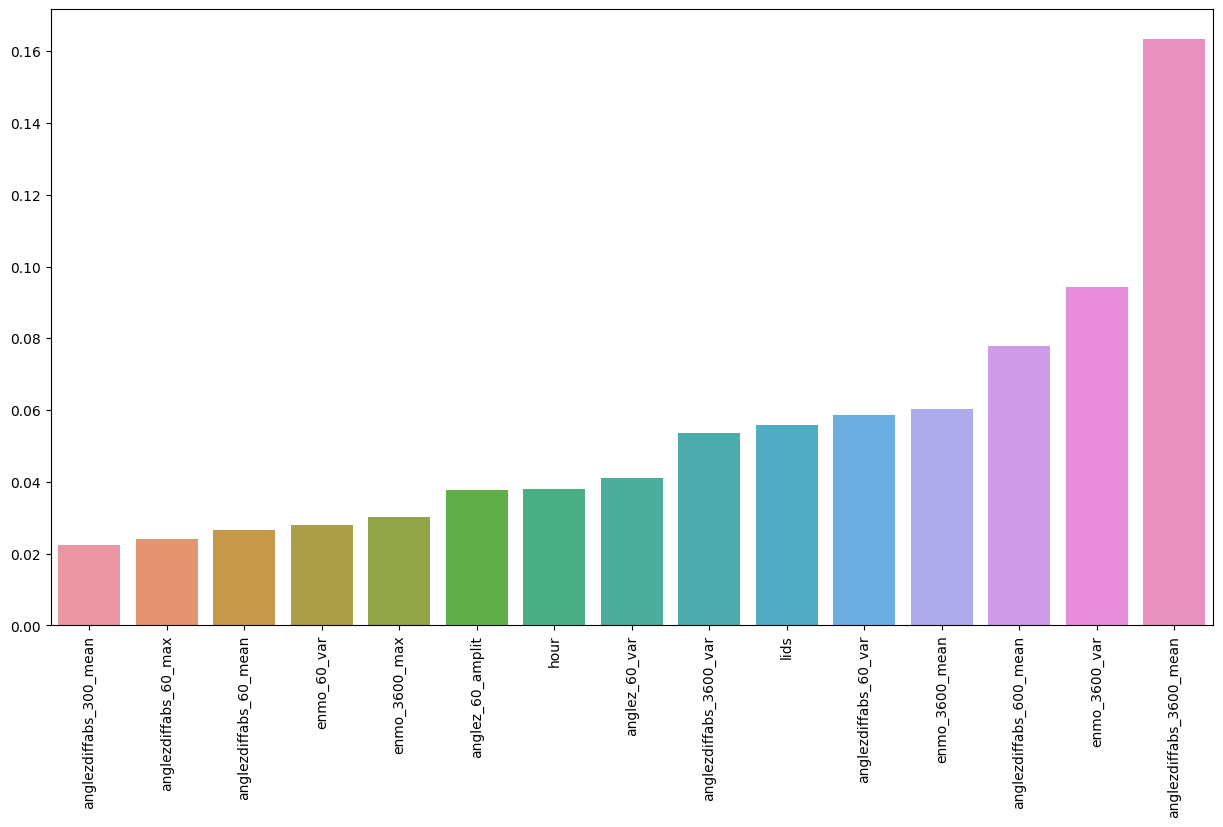

In [72]:
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
sns.barplot(x=feature_importance[-15:].index, y=feature_importance[-15:].values)

In [73]:
features_to_drop = feature_importance.head(60).index.to_list()

In [74]:
df = df.drop(columns=features_to_drop)
features = [col for col in df.columns if col not in ['timestamp', 'series_id', 'step', 'awake']]

In [75]:
print(f"Fitting model with {len(df.columns)-4} features")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = train_model(df, kf)

Fitting model with 15 features
Fitting model 1 of 5
Fold 1 finished training
F1: 0.9840074438079731 | Acc: 0.9791116765727959
Fitting model 2 of 5
Fold 2 finished training
F1: 0.984447222302974 | Acc: 0.9796813581208105
Fitting model 3 of 5
Fold 3 finished training
F1: 0.9842960732946404 | Acc: 0.9793961260919104
Fitting model 4 of 5
Fold 4 finished training
F1: 0.9845543062478267 | Acc: 0.9797569312571212
Fitting model 5 of 5
Fold 5 finished training
F1: 0.98359080386133 | Acc: 0.9785985567793392
--------------------------------------------------
Training finished
F1: 0.984179169902949, Acc: 0.9793089297643954


In [76]:
fi = pd.DataFrame([pd.Series(model.feature_importances_, index=features) for model in models])
feature_importance = fi.mean(axis=0).sort_values()

<Axes: >

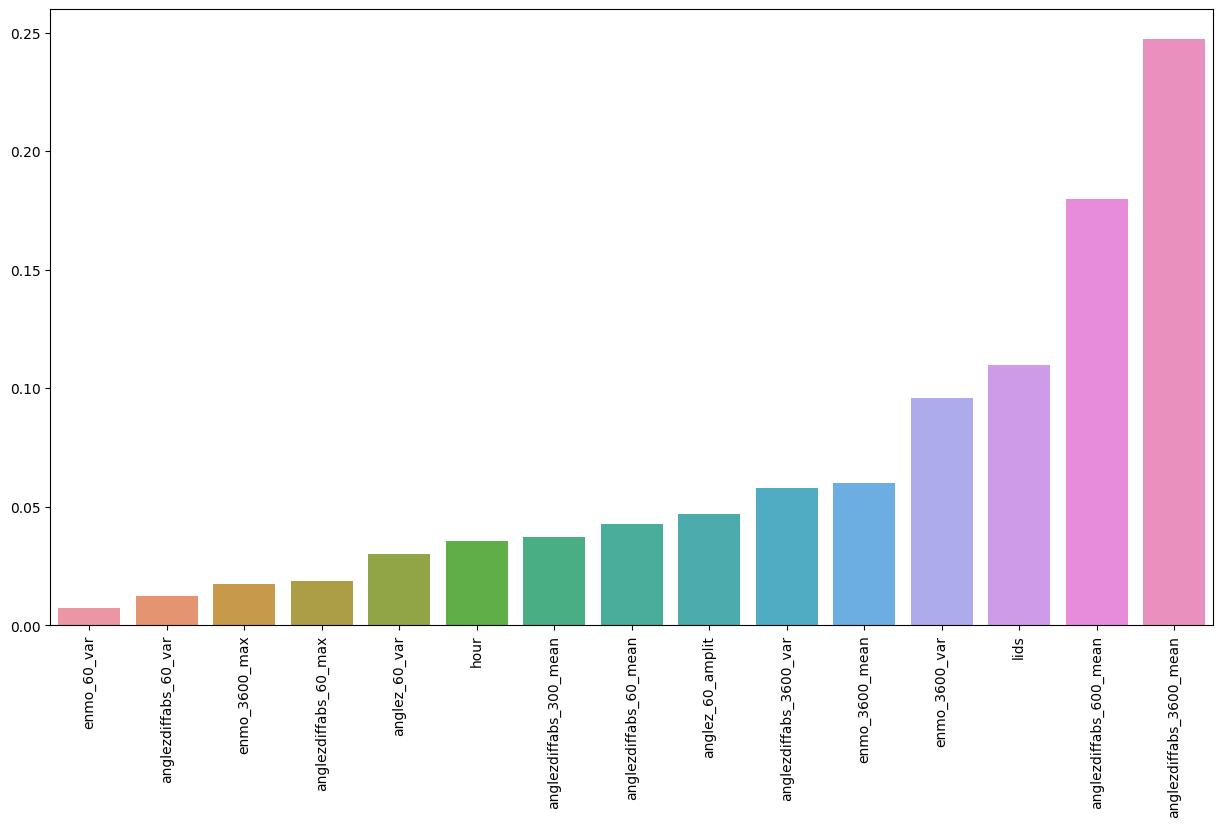

In [77]:
plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
sns.barplot(x=feature_importance[-15:].index, y=feature_importance[-15:].values)